In [90]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F

import os
import cv2
from tqdm import tqdm
import argparse
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("../")
from per_segment_anything import sam_model_registry, SamPredictor

In [91]:
from IPython.display import display, Image

In [92]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [93]:
ref_folder_path = "ref_pd"
images_folder_path = "test_pd"
output_path = 'outputs_pd'
ext = "jpg"

os.makedirs(output_path, exist_ok=True)

In [94]:
lr = 1e-3
train_epoch = 1000
log_epoch = 200
sam_type = "vit_t"

In [95]:
print("======> Load SAM" )
if sam_type == 'vit_h':
    sam_type, sam_ckpt = 'vit_h', '../sam/sam_vit_h.pth'
    sam = sam_model_registry[sam_type](checkpoint=sam_ckpt).cuda()
elif sam_type == 'vit_t':
    sam_type, sam_ckpt = 'vit_t', '../sam/mobile_sam.pt'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sam = sam_model_registry[sam_type](checkpoint=sam_ckpt).to(device=device)
    sam.eval()


for name, param in sam.named_parameters():
    param.requires_grad = False
predictor = SamPredictor(sam)

======> Load SAM


In [96]:
print("\n------------> Segment ")
    
# Path preparation
ref_image_path = os.path.join(ref_folder_path, f'original.{ext}')
ref_mask_path = os.path.join(ref_folder_path, f'mask.{ext}')
# test_images_path = images_folder_path
test_images_path = "../"

# Load images and masks
ref_image = cv2.imread(ref_image_path)
ref_image = cv2.cvtColor(ref_image, cv2.COLOR_BGR2RGB)
# ref_image = cv2.resize(ref_image,None,fx=0.1,fy=0.1)

ref_mask = cv2.imread(ref_mask_path)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2RGB)
# ref_mask = cv2.resize(ref_mask,None,fx=0.1,fy=0.1)

gt_mask = torch.tensor(ref_mask)[:, :, 0] > 0 
gt_mask = gt_mask.float().unsqueeze(0).flatten(1).cuda()


------------> Segment 


In [97]:
print("======> Obtain Self Location Prior" )
# Image features encoding
print(ref_image.shape, ref_mask.shape)
ref_mask = predictor.set_image(ref_image, ref_mask)
print(ref_mask.shape)
ref_feat = predictor.features.squeeze().permute(1, 2, 0)
print(ref_feat.shape)
ref_mask = F.interpolate(ref_mask, size=ref_feat.shape[0: 2], mode="bilinear")
ref_mask = ref_mask.squeeze()[0]
print(ref_mask.shape)

# Target feature extraction
# target_feat = ref_feat[ref_mask > 0]
# target_feat_mean = target_feat.mean(0)
# target_feat_max = torch.max(target_feat, dim=0)[0]
# target_feat = (target_feat_max / 2 + target_feat_mean / 2).unsqueeze(0)
target_feat = ref_feat[ref_mask > 0]
target_embedding = target_feat.mean(0).unsqueeze(0).unsqueeze(0)
target_feat_mean = target_feat.mean(0)
target_feat_max = torch.max(target_feat, dim=0)[0]
target_feat = (target_feat_max / 2 + target_feat_mean / 2).unsqueeze(0)


# # Cosine similarity
# h, w, C = ref_feat.shape
# target_feat = target_feat / target_feat.norm(dim=-1, keepdim=True)
# ref_feat = ref_feat / ref_feat.norm(dim=-1, keepdim=True)
# ref_feat = ref_feat.permute(2, 0, 1).reshape(C, h * w)
# sim = target_feat @ ref_feat

# sim = sim.reshape(1, 1, h, w)
# sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
# sim = predictor.model.postprocess_masks(
#                 sim,
#                 input_size=predictor.input_size,
#                 original_size=predictor.original_size).squeeze()

======> Obtain Self Location Prior
(480, 640, 3) (480, 640, 3)
torch.Size([1, 3, 1024, 1024])
torch.Size([64, 64, 256])
torch.Size([64, 64])


In [98]:
def sim_to_heatmap(sim, th = 0):
    if torch.is_tensor(sim):
        x = sim.to("cpu").detach().numpy().copy()
    else:
        x = sim.copy()
    h, w = x.shape
    x = (x - np.min(x)) / (np.max(x) - np.min(x))
    x[x < th] = 0
    x = (x * 255).reshape(-1)
    
    cm = plt.get_cmap("jet")
    x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
    return (x * 255).astype(np.uint8).reshape(h, w, 3)

In [99]:
print('======> Start Testing')

# Load test image
# file_name = 'image_almi'
file_name = 'positon_detector_original'
test_image_path = os.path.join(test_images_path, f"{file_name}.{ext}" )
test_image = cv2.imread(test_image_path)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

# Image feature encoding
predictor.set_image(test_image)
test_feat_ = predictor.features.squeeze()

# Cosine similarity
C, h, w = test_feat_.shape
test_feat_ = test_feat_ / test_feat_.norm(dim=0, keepdim=True)
test_feat_ = test_feat_.reshape(C, h * w)
sim = target_feat @ test_feat_

sim = sim.reshape(1, 1, h, w)
sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
sim = predictor.model.postprocess_masks(
                sim,
                input_size=predictor.input_size,
                original_size=predictor.original_size).squeeze()


======> Start Testing


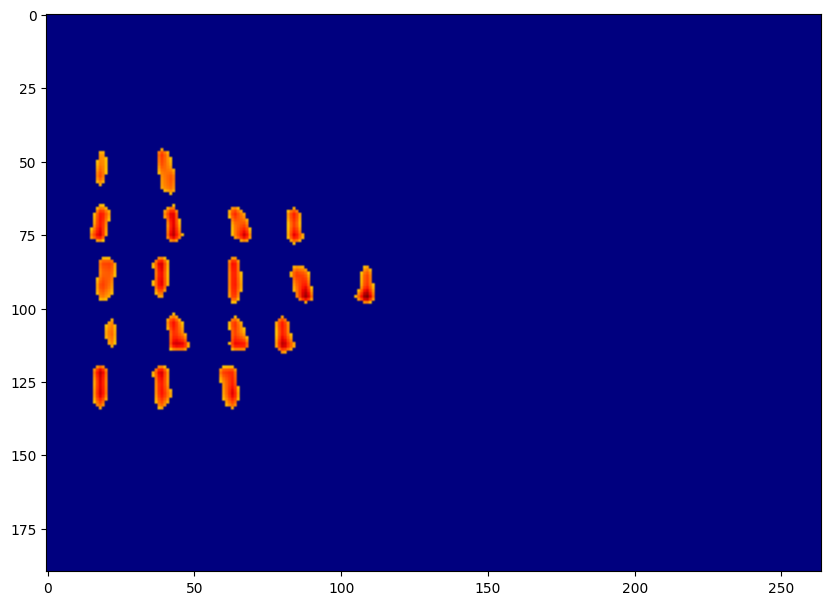

In [100]:
heat_map = sim_to_heatmap(sim, th=0.7)
plt.figure(figsize=(10,10))
plt.imshow(heat_map)
plt.axis('on')
plt.show()  
plt.close()

In [101]:
from scipy.ndimage import maximum_filter
def detect_peaks(image, filter_size=3, order=0.5):
    local_max = maximum_filter(image, footprint=np.ones((filter_size, filter_size)), mode='constant')
    detected_peaks = np.ma.array(image, mask=~(image == local_max))
    
    # 小さいピーク値を排除（最大ピーク値のorder倍のピークは排除）
    temp = np.ma.array(detected_peaks, mask=~(detected_peaks >= detected_peaks.max() * order))
    peaks_index = np.where((temp.mask != True))
    peaks_index =np.array(peaks_index).T
    # print(f"detect {len(peaks_index[0])} peaks: {peaks_index}")
    peaks_index = sorted(peaks_index, key=lambda x: x[1])
    peaks_index =np.array(peaks_index).T
    print(f"detect {len(peaks_index[0])} peaks: {peaks_index}")
    return peaks_index

def getPeaks(test_image, filter_size=100, order=0.7, save_sim=False):
    sim = getSimirality(test_image)
    peaks_index = detect_peaks(sim.cpu().detach().numpy(), order=order, filter_size=filter_size)
    fig = plt.figure()
    if save_sim:
        heatmap = sim_to_heatmap(sim)
        # plt.imshow(heatmap)
        for i in range(len(peaks_index[0])):
            cv2.circle(heatmap, (peaks_index[1][i], peaks_index[0][i]), radius=3, color=(0, 0, 0), thickness=-1)
            cv2.putText(heatmap, 'PEAK!!!', (peaks_index[1][i], peaks_index[0][i]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)    
            # plt.scatter(peaks_index[1][i], peaks_index[0][i], color='black', s=5)
            # plt.text(peaks_index[1][i],peaks_index[0][i], 'PEAK!!!', fontsize=9)
        # plt.axis("off")
        # plt.savefig("positon_detector_similarity.jpg")
        # plt.close()
        # cv2.imwrite("positon_detector_original.jpg", test_image)   
        # cv2.imwrite("positon_detector_similarity.jpg", cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))   
        fig.add_subplot(1,2,1).set_title("original")
        plt.imshow(test_image)
        plt.axis('off')

        fig.add_subplot(1,2,2).set_title("similarity")
        plt.imshow(heatmap)
        plt.axis('off')
        plt.show()

        plt.imshow(heatmap)
        plt.axis('off')
        plt.show()
    plt.close()
    return peaks_index

def getSimirality(test_image, save_sim=False):
    # Image feature encoding
    predictor.set_image(test_image)
    test_feat_ = predictor.features.squeeze()
    # Cosine similarity
    C, h, w = test_feat_.shape
    test_feat_ = test_feat_ / test_feat_.norm(dim=0, keepdim=True)
    test_feat_ = test_feat_.reshape(C, h * w)
    sim = target_feat @ test_feat_
    sim = sim.reshape(1, 1, h, w)
    sim = F.interpolate(sim, scale_factor=4, mode="bilinear")
    sim = predictor.model.postprocess_masks(
                    sim,
                    input_size=predictor.input_size,
                    original_size=predictor.original_size).squeeze()
    return sim

detect 14 peaks: [[ 55  75 122 109  48  75 112 129 112  75 112  75  96  96]
 [ 18  18  18  22  39  43  44  63  64  67  80  84  88 109]]


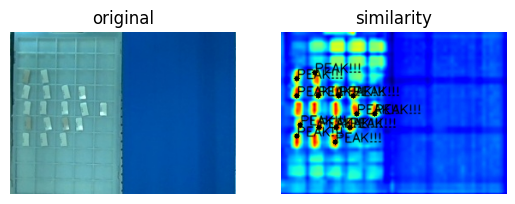

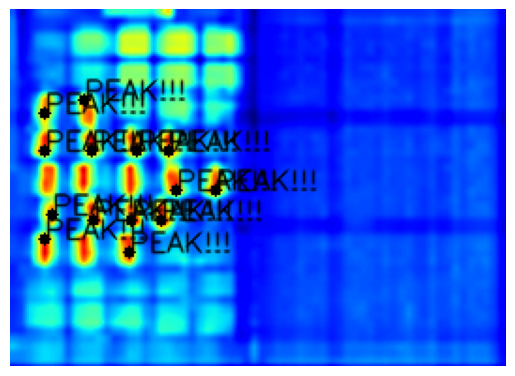

In [102]:
peaks_pixels = getPeaks(test_image, filter_size=20, order=0.7, save_sim=True)

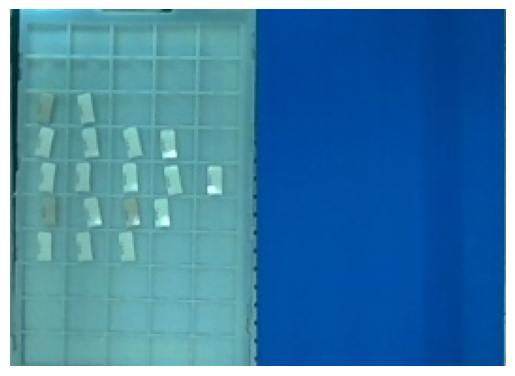

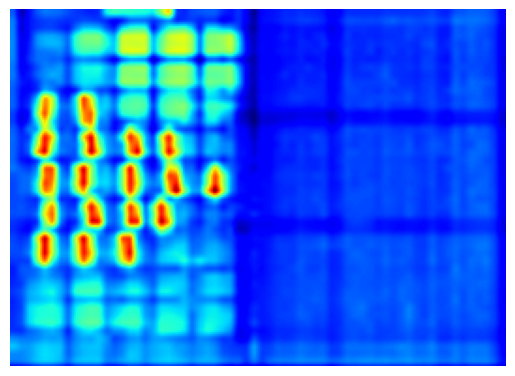

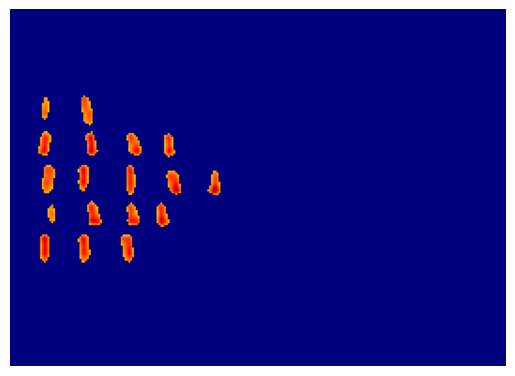

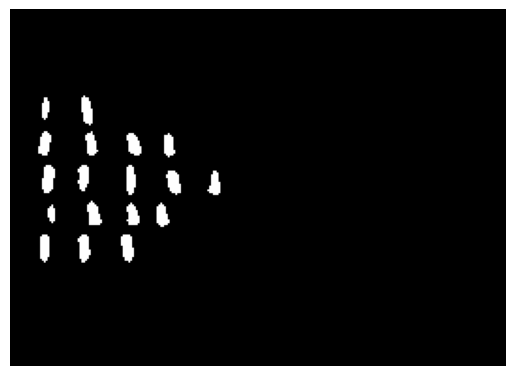

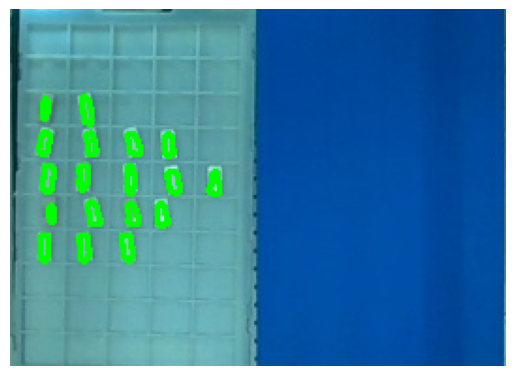

18
[[ 62  39  18  22  80  65  44 109  87  64  39  20  84  65  43  18  18  40]
 [126 127 127 109 110 109 109  93  92  90  89  90  72  72  72  71  52  54]]


In [103]:
def countObjects(image, filter_size=100, order=0.7, save_sim=False):
    original_image = image.copy()
    plt.figure()
    # fig.add_subplot(1,3,1).set_title("original")
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()


    sim = getSimirality(image)
    heatmap = sim_to_heatmap(sim)
    
    plt.imshow(heatmap)
    plt.axis('off')
    plt.show()


    heatmap = sim_to_heatmap(sim, th=0.7)

    plt.imshow(heatmap)
    plt.axis('off')
    plt.show()

    image_hsv = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)
    # image_gauss = cv2.GaussianBlur(image_hsv,(9, 9),3)
    img_H, img_S, img_V = cv2.split(image_hsv)
    _thre, image_mask = cv2.threshold(img_H, 0, 30, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(image_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) #img_binaryを輪郭抽出
    
    image_contours = cv2.drawContours(image, contours, -1, (0,255,0), 2) #抽出した輪郭を緑色でimg_colorに重ね書き
    
    plt.imshow(image_mask, cmap='gray')
    plt.axis('off')
    plt.show()
    
    plt.imshow(image_contours)
    plt.axis('off')
    plt.show()

    print(len(contours))

    x_list = []
    y_list = []
    for i in range(0, len(contours)):
        if len(contours[i]) > 0:
            if cv2.contourArea(contours[i]) < 20:
                continue
            # 重心の計算
            m = cv2.moments(contours[i])
            x,y= m['m10']/m['m00'] , m['m01']/m['m00']
            # print(f"Weight Center = ({x}, {y})")
            # 座標を四捨五入
            x, y = round(x), round(y)
            x_list.append(x)
            y_list.append(y)
    return np.array([x_list, y_list])

print(countObjects(test_image, filter_size=20, order=0.7, save_sim=True))